## Import Libs

In [103]:
path = '..'

In [104]:
import json
import csv

import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

nltk.download('stopwords')
nltk.download('sentiwordnet')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /Users/salam/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package sentiwordnet to
[nltk_data]     /Users/salam/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/salam/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [105]:
parts = ['part1', 'part2']

## Load Datasets

In [106]:
with open(path + '/dataset/en.json', 'r') as file:
    en_book = json.load(file)

In [107]:
with open(path+'/dataset/kaz.json', 'r') as file:
    kaz_book = json.load(file)

In [108]:
with open(path+'/dataset/ru.json', 'r') as file:
    ru_book = json.load(file)

In [109]:
def print_json_hierarchy(json_data, level=0):
    if isinstance(json_data, dict):
        for key, value in json_data.items():
            print('\t' * level + key)
            if isinstance(value, dict):
                print_json_hierarchy(value, level + 1)
    elif isinstance(json_data, list):
        for item in json_data:
            print('\t' * level + 'item')
            if isinstance(item, dict):
                print_json_hierarchy(item, level + 1)

In [110]:
kaz_nrc_data = pd.read_csv(path + '/dataset/Kazakh-NRC-EmoLex.txt', sep='\t')
ru_nrc_data = pd.read_csv(path + '/dataset/Russian-NRC-EmoLex.txt', sep='\t')

### Сontent of the Original Kazakh version

In [111]:
print_json_hierarchy(kaz_book)

chapters_in_kaz
	part1
		kaitkanda
		kat_kabatta
		zholda
		shytyrmanda
		bel_beleste
		orde
		kyiada
	part2
		zhailauda
		enyste
		okapta
		asuda
		tarauda
		biykte
		epilogue
part1
	kaitkanda
	kat_kabatta
	zholda
	shytyrmanda
	bel_beleste
	orde
	kyiada
part2
	zhailauda
	enyste
	okapta
	asuda
	tarauda
	biykte
	epilogue


### Сontent of the English version

In [112]:
print_json_hierarchy(en_book)

part1
	the_home_coming
	the_whirlwind
	on_the_road
	in_the_thickets
	along_the_foothills
	the_ascent
	in_the_heights
part2
	the_ford
	the_foothills
	over_the_ruts
	through_the_pass
	at_the_crossroads
	at_the_summit
	epilogue


### Сontent of the Russian version

In [113]:
print_json_hierarchy(ru_book)

part1
	возвращение
	в_вихре
	в_пути
	в_дебрях
	по_предгорьям
	на_подъеме
	в_вышине
part2
	перед_бродом
	на_жайляу
	взгорьями
	по_рытвинам
	на_перевале
	на_распутье
	эпилог


## Pre-Processing

In [114]:
def remove_stopwords(sentence: list[str], language: str):
    stop_words = set(stopwords.words(language))
    return [word for word in sentence if word.lower() not in stop_words]

### Remove Stop Words

In [115]:
books = {'english': en_book, 'kazakh': kaz_book, 'russian': ru_book}

In [116]:
for part in parts:
    for language in ['english', 'kazakh', 'russian']:
        book = books[language]
        for chapter in book[part]:
            for i in range(len(book[part][chapter])):
                sentence = book[part][chapter][i]
                sentence = remove_stopwords(sentence, language)
                book[part][chapter][i] = sentence

## Emotion Analysis English Version

In [117]:
EMOTIONS = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']

In [118]:
def plot_emotions(emotion_scores: dict, part1_chapters: list["str"], part2_chapters: list["str"], step: int = 1):
    fig, axs = plt.subplots(len(EMOTIONS), 14, figsize=(28, 20))

    for i in range(len(EMOTIONS)):
        for j in range(7):
            part1_values = [emotion[i] for emotion in emotion_scores['part1'][part1_chapters[j]]]
            axs[i][j].plot(part1_values[::step])
            if i == 0:
                axs[i][j].set_title(part1_chapters[j])
            axs[i][j].set_yticks([])
                
            part2_values = [emotion[i] for emotion in emotion_scores['part2'][part2_chapters[j]]]
            axs[i][j+7].plot(part2_values[::step])
            if i == 0:
                axs[i][j+7].set_title(part2_chapters[j])
            axs[i][j+7].set_yticks([])

        axs[i][0].set_ylabel(EMOTIONS[i])

    plt.show()

In [119]:
def plot_emotions2(emotion_scores: dict, part1_chapters: list["str"], part2_chapters: list["str"], step: int):
    fig, axs = plt.subplots(2, 7, figsize=(15, 8))

    for i in range(7):
        axs[0, i].plot(emotion_scores['part1'][part1_chapters[i]][::step])
        axs[0, i].set_title(part1_chapters[i])
        axs[1, i].plot(emotion_scores['part2'][part2_chapters[i]][::step])
        axs[1, i].set_title(part2_chapters[i])

    plt.legend(EMOTIONS, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

In [120]:
def plot_emotion_heatmap(emotions_mean: dict, part1_chapters: list["str"], part2_chapters: list["str"]):
    df1 = pd.DataFrame(emotions_mean['part1'], index=EMOTIONS)
    df2 = pd.DataFrame(emotions_mean['part2'], index=EMOTIONS)

    df3 = pd.concat([df1, df2], axis=1)

    df3.columns = part1_chapters + part2_chapters

    plt.figure(figsize=(10, 6))
    sns.heatmap(df3, cmap='magma')
    plt.show()

In [121]:
def plot_emotions_mean(emotions_mean: dict):
    fig, axs = plt.subplots(2, 1, figsize=(6, 10))

    axs[0].plot(emotions_mean['part1'].keys(), emotions_mean['part1'].values(), marker='o')
    axs[0].xaxis.set_tick_params(rotation=13)
    axs[0].set_title('Part 1')

    axs[1].plot(emotions_mean['part2'].keys(), emotions_mean['part2'].values(), marker='o')
    axs[1].xaxis.set_tick_params(rotation=13)
    axs[1].set_title('Part 2')

    plt.legend(EMOTIONS, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

In [122]:
kaz_nrc_data

English Word  anger  anticipation  disgust  fear  joy  negative  \
0            aback      0             0        0     0    0         0   
1           abacus      0             0        0     0    0         0   
2          abandon      0             0        0     1    0         1   
3        abandoned      1             0        0     1    0         1   
4      abandonment      1             0        0     1    0         1   
...            ...    ...           ...      ...   ...  ...       ...   
14149         zone      0             0        0     0    0         0   
14150          zoo      0             0        0     0    0         0   
14151   zoological      0             0        0     0    0         0   
14152      zoology      0             0        0     0    0         0   
14153         zoom      0             0        0     0    0         0   

       positive  sadness  surprise  trust       Kazakh Word  
0             0        0         0      0         таң қалды  
1             0        0         0      1            абакус  
2             0        1         0      0            тастау  
3             0        1         0      0     тастап кеткен  
4             0        1         1      0         бас тарту  
...         ...      ...       ...    ...               ...  
14149         0        0         0      0             аймақ  
14150         0        0         0      0  хайуанаттар бағы  
14151         0        0         0      0       зоологиялық  
14152         0        0         0      0          зоология  
14153         0        0         0      0        масштабтау  

[14154 rows x 12 columns]

### Using NRC EmotionLex

In [123]:
def preprocess_nrc_data(nrc_data, lang):
    sentiment_dict = {}
    for index, row in nrc_data.iterrows():
        word = row[lang]
        emotion = [row[emotion] for emotion in EMOTIONS]   
        if emotion:         
            sentiment_dict[word] = emotion
    return sentiment_dict

In [124]:
kaz_emotion_dict = preprocess_nrc_data(kaz_nrc_data, "Kazakh Word")
en_emotion_dict = preprocess_nrc_data(kaz_nrc_data, "English Word")
ru_emotion_dict = preprocess_nrc_data(ru_nrc_data, "Russian Word")

In [125]:
def get_emotion(emotion_dict: dict, sentence: list[str]):
    emotion_sequence = []
    for word in sentence:
        if word in emotion_dict:
            emotions = emotion_dict[word]
            if emotions:
                emotion_sequence.append(emotions)
    return emotion_sequence

In [126]:
en_emotions = {}

for part in parts:
    en_emotions[part] = {}
    book = books['english']
    for chapter in book[part]:
        en_emotions[part][chapter] = []
        for sentence in book[part][chapter]:
            emotion = get_emotion(en_emotion_dict, sentence)
            if emotion:
                en_emotions[part][chapter].append(np.mean(emotion, axis=0))

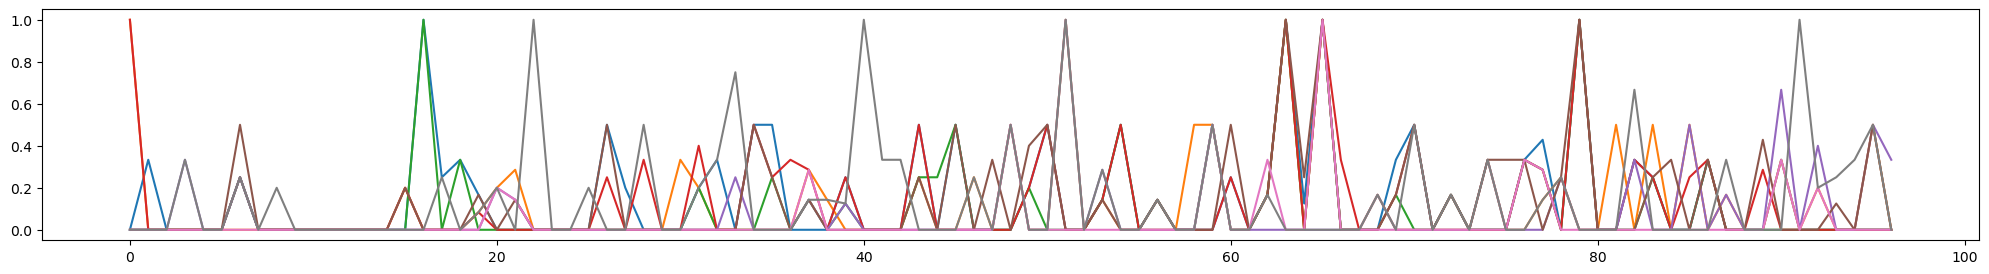

In [127]:
fig = plt.figure(figsize=(25, 3))
plt.plot(en_emotions['part1']['the_home_coming'][::10])
plt.show()

In [128]:
chapter1 = ['the_home_coming', 'the_whirlwind', 'on_the_road', 'in_the_thickets', 'along_the_foothills', 'the_ascent', 'in_the_heights']
chapter2 = ['the_ford', 'the_foothills', 'over_the_ruts', 'through_the_pass', 'at_the_crossroads', 'at_the_summit', 'epilogue']

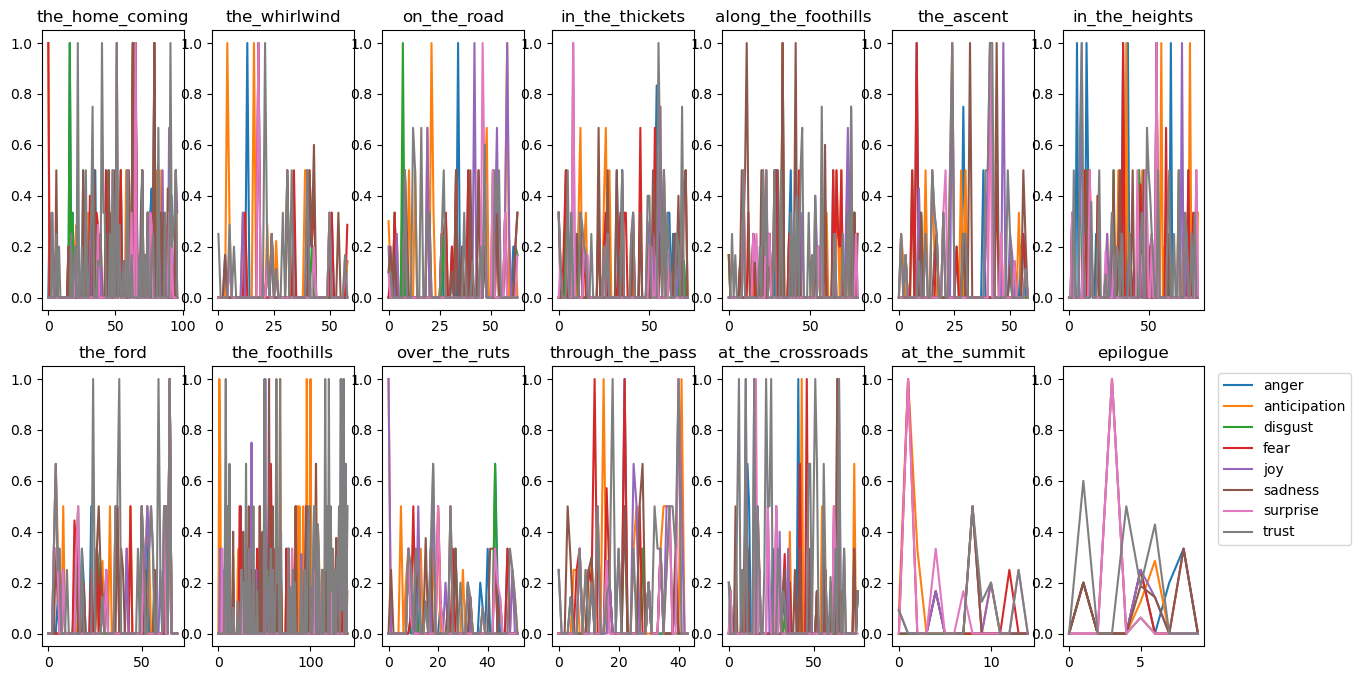

In [129]:
plot_emotions2(en_emotions, chapter1, chapter2, step=10)

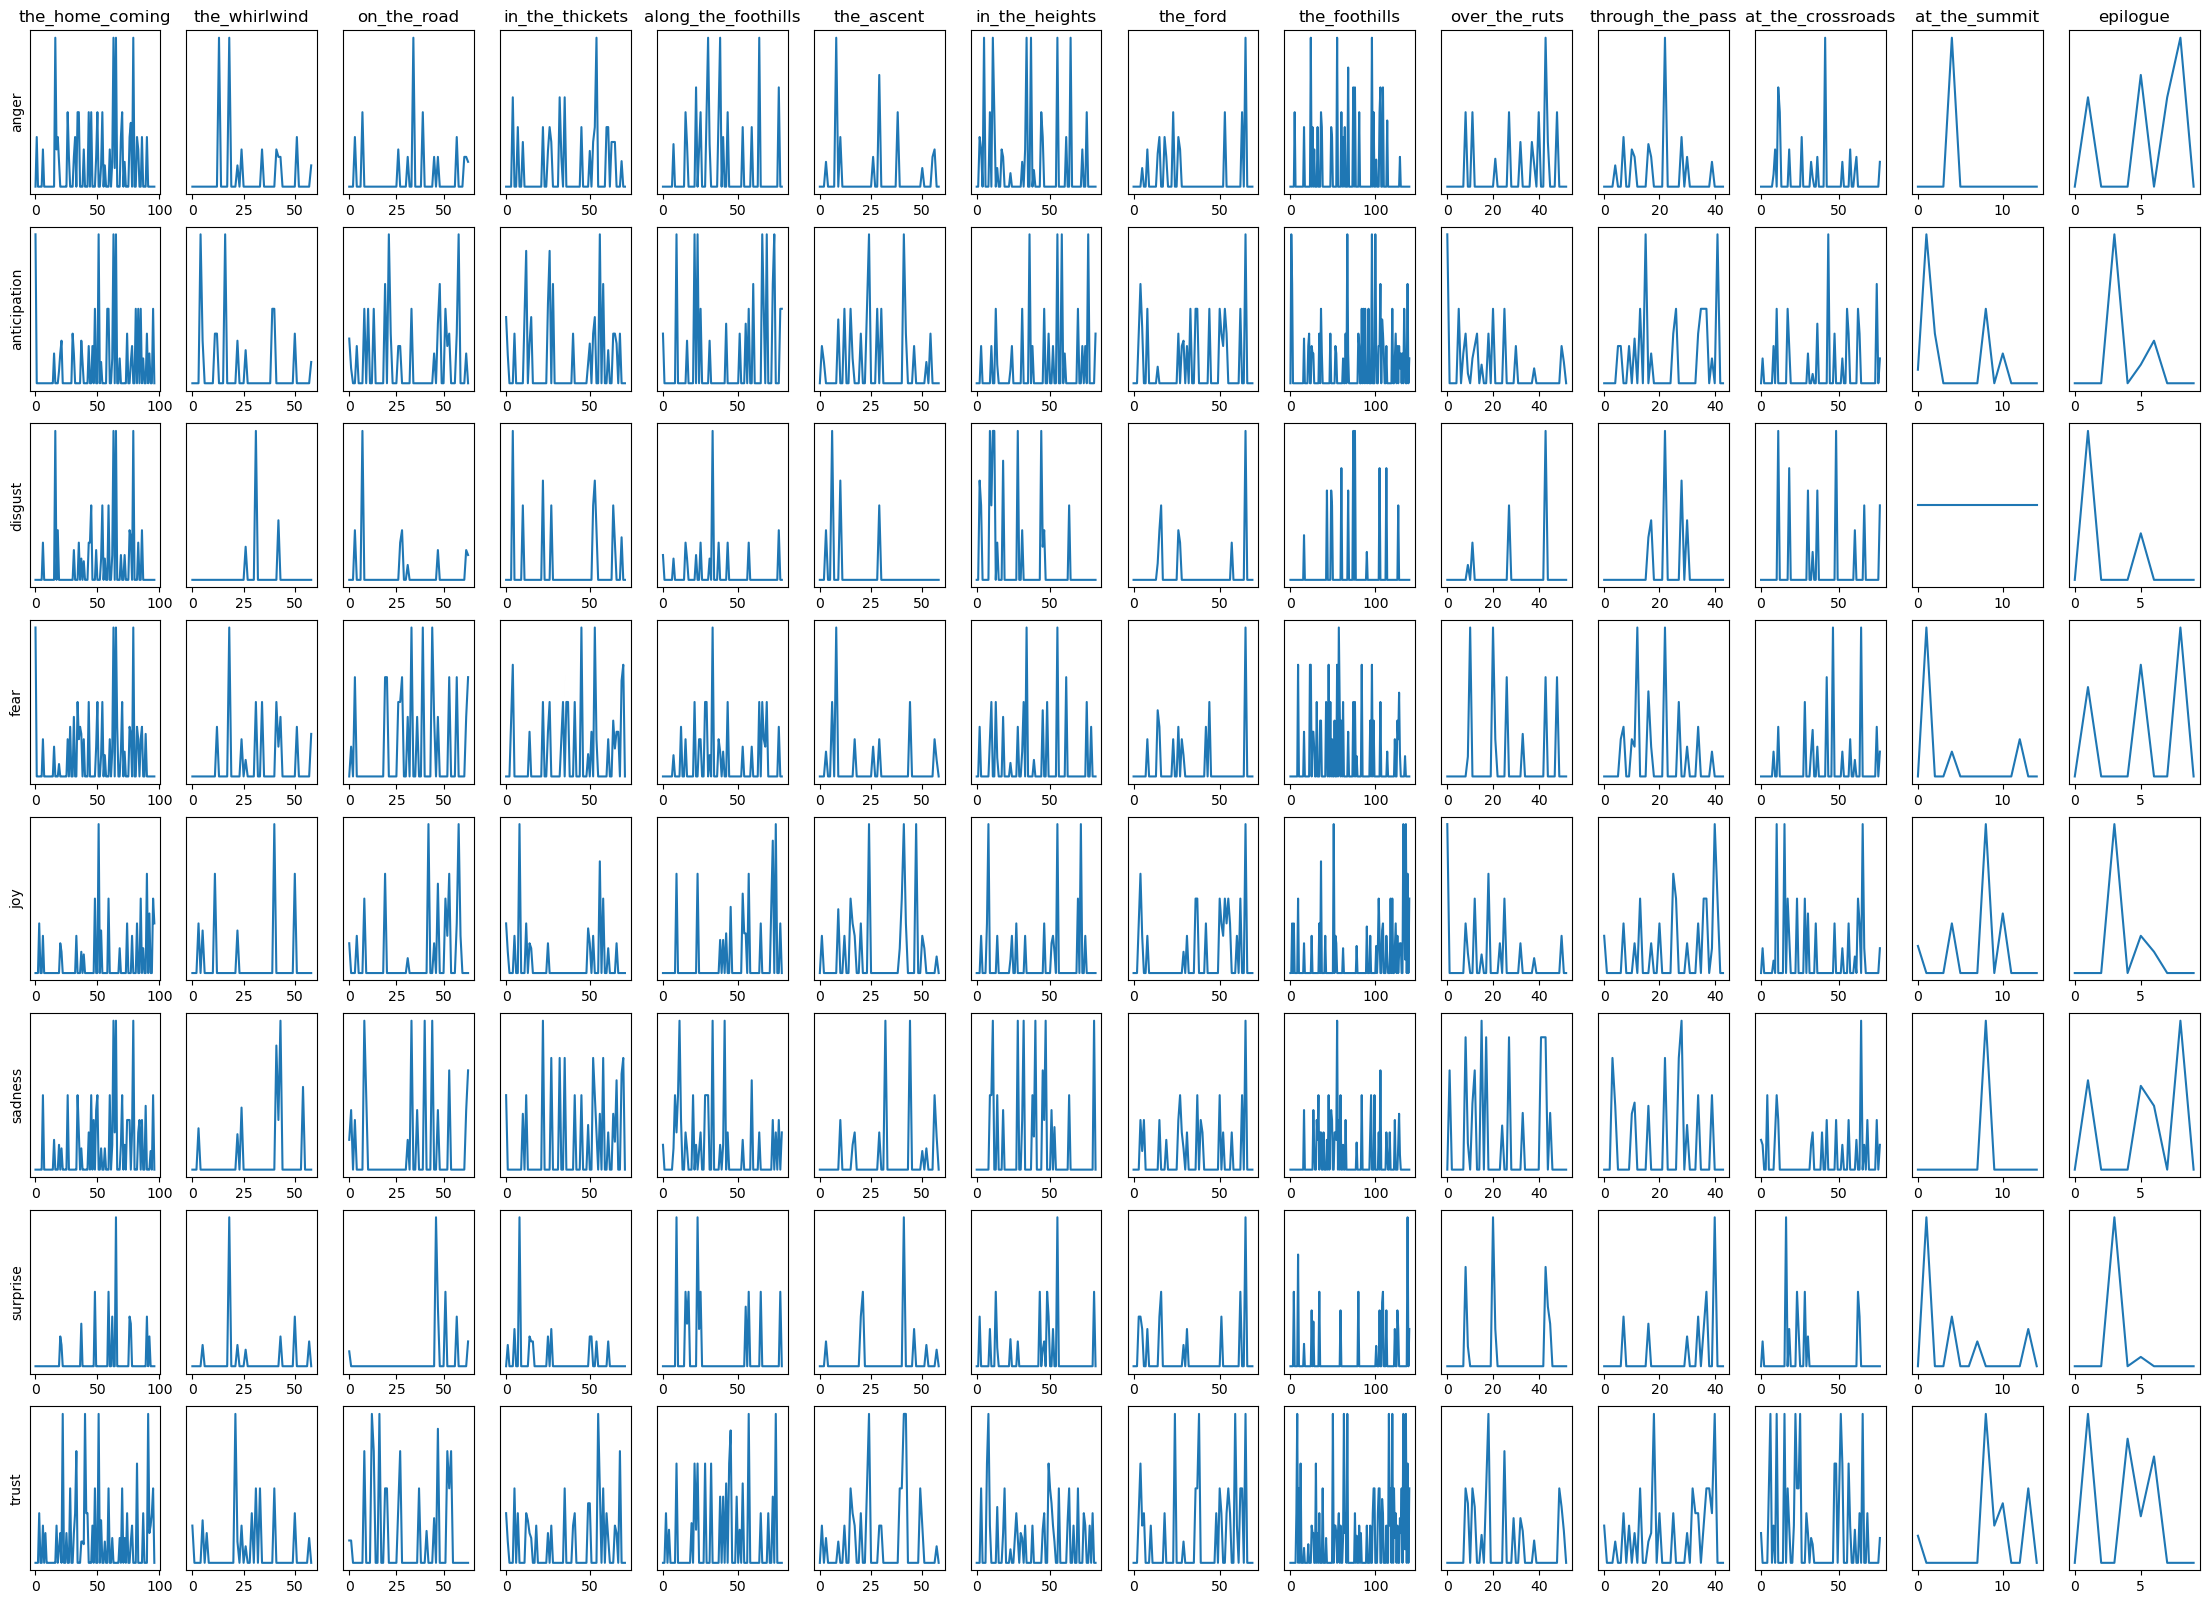

In [130]:
plot_emotions(en_emotions, chapter1, chapter2, step=10)

In [131]:
en_emotions_mean = {}

for part in parts:
    en_emotions_mean[part] = {}
    for chapter in en_emotions[part].keys():
      en_emotions_mean[part][chapter] = np.mean(en_emotions[part][chapter], axis=0)

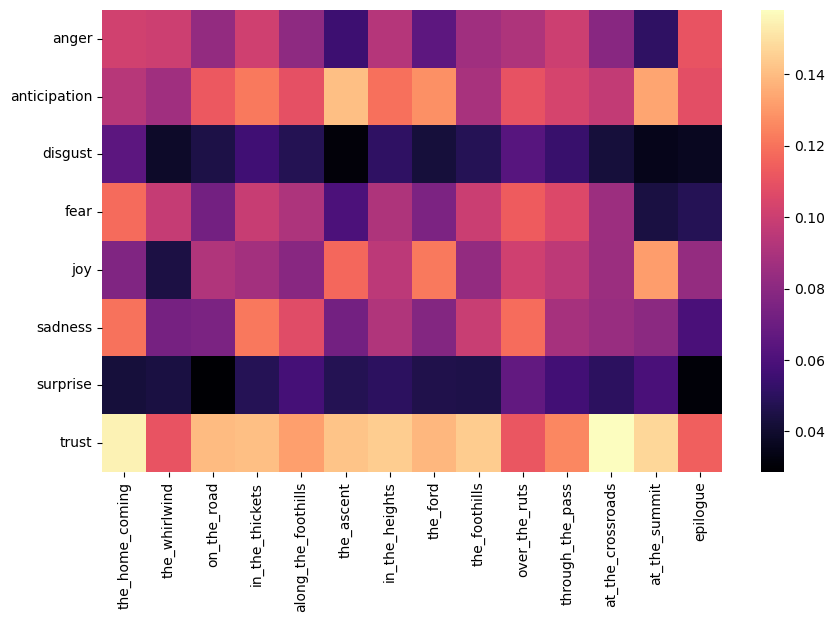

In [132]:
plot_emotion_heatmap(en_emotions_mean, chapter1, chapter2)

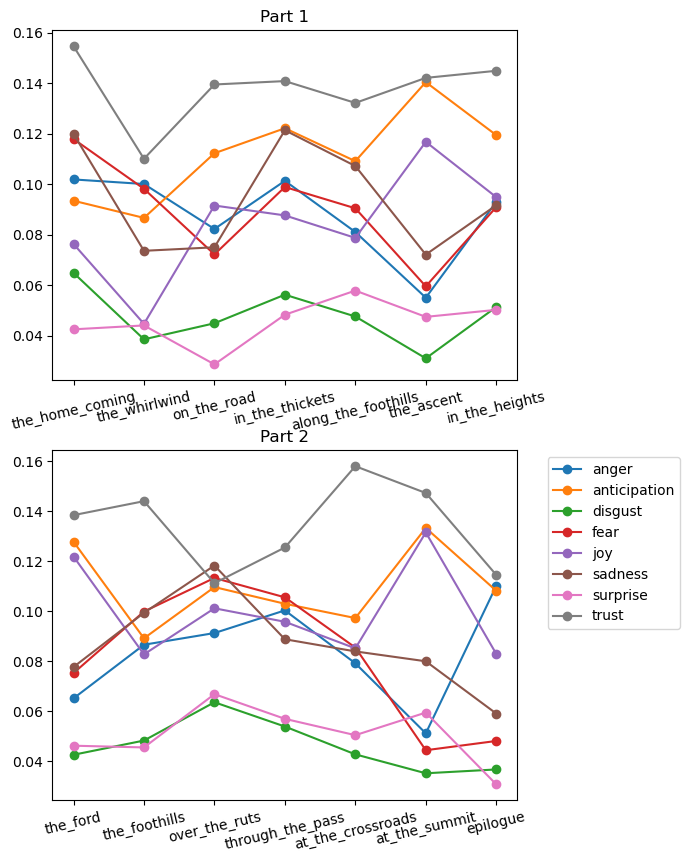

In [133]:
plot_emotions_mean(en_emotions_mean)

## Sentiment Analysis Russian Version

In [134]:
ru_emotions = {}

for part in parts:
    ru_emotions[part] = {}
    book = books['russian']
    for chapter in book[part]:
        ru_emotions[part][chapter] = []
        for sentence in book[part][chapter]:
            emotion = get_emotion(ru_emotion_dict, sentence)
            if emotion:
                ru_emotions[part][chapter].append(np.mean(emotion, axis=0))

In [135]:
ru_part1_chapters = [chapter for chapter in ru_emotions['part1'].keys()]
ru_part2_chapters = [chapter for chapter in ru_emotions['part2'].keys()]

In [136]:
ru_emotion_mean = {}

for part in parts:
    ru_emotion_mean[part] = {}
    for chapter in ru_emotions[part].keys():
      ru_emotion_mean[part][chapter] = np.mean(ru_emotions[part][chapter], axis=0)

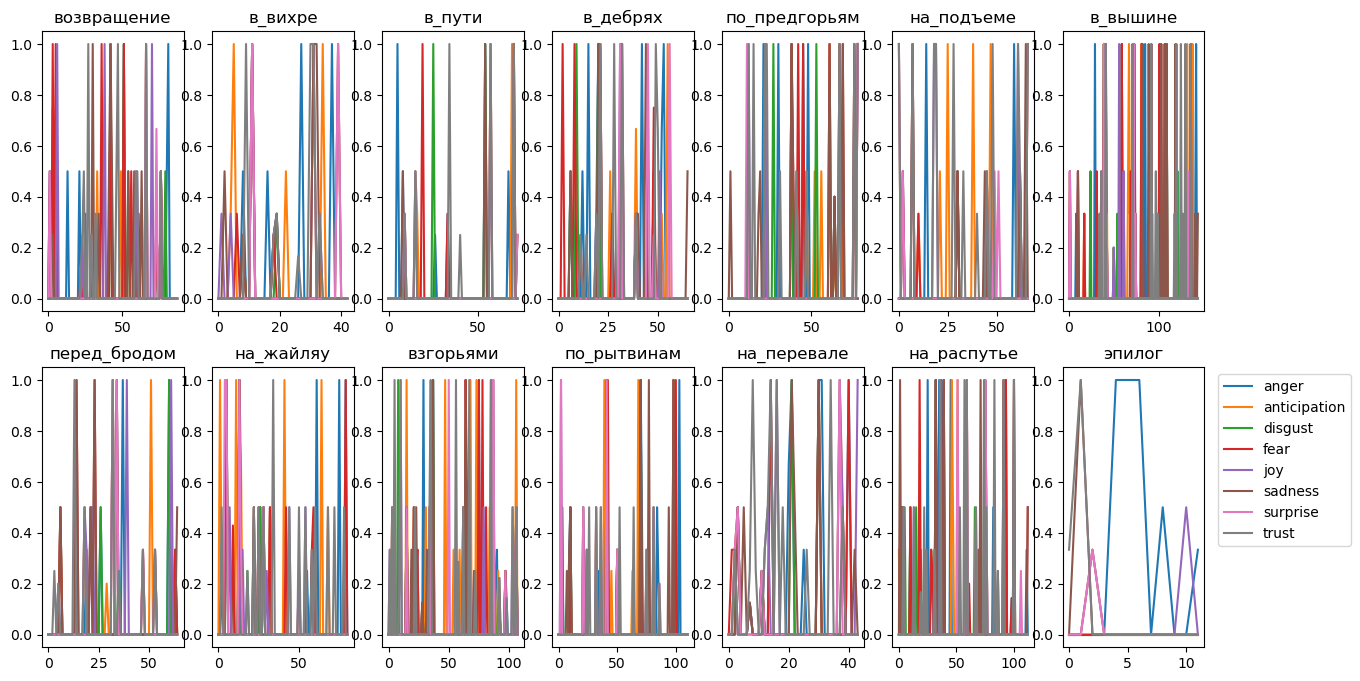

In [137]:
plot_emotions2(ru_emotions, ru_part1_chapters, ru_part2_chapters, step=10)

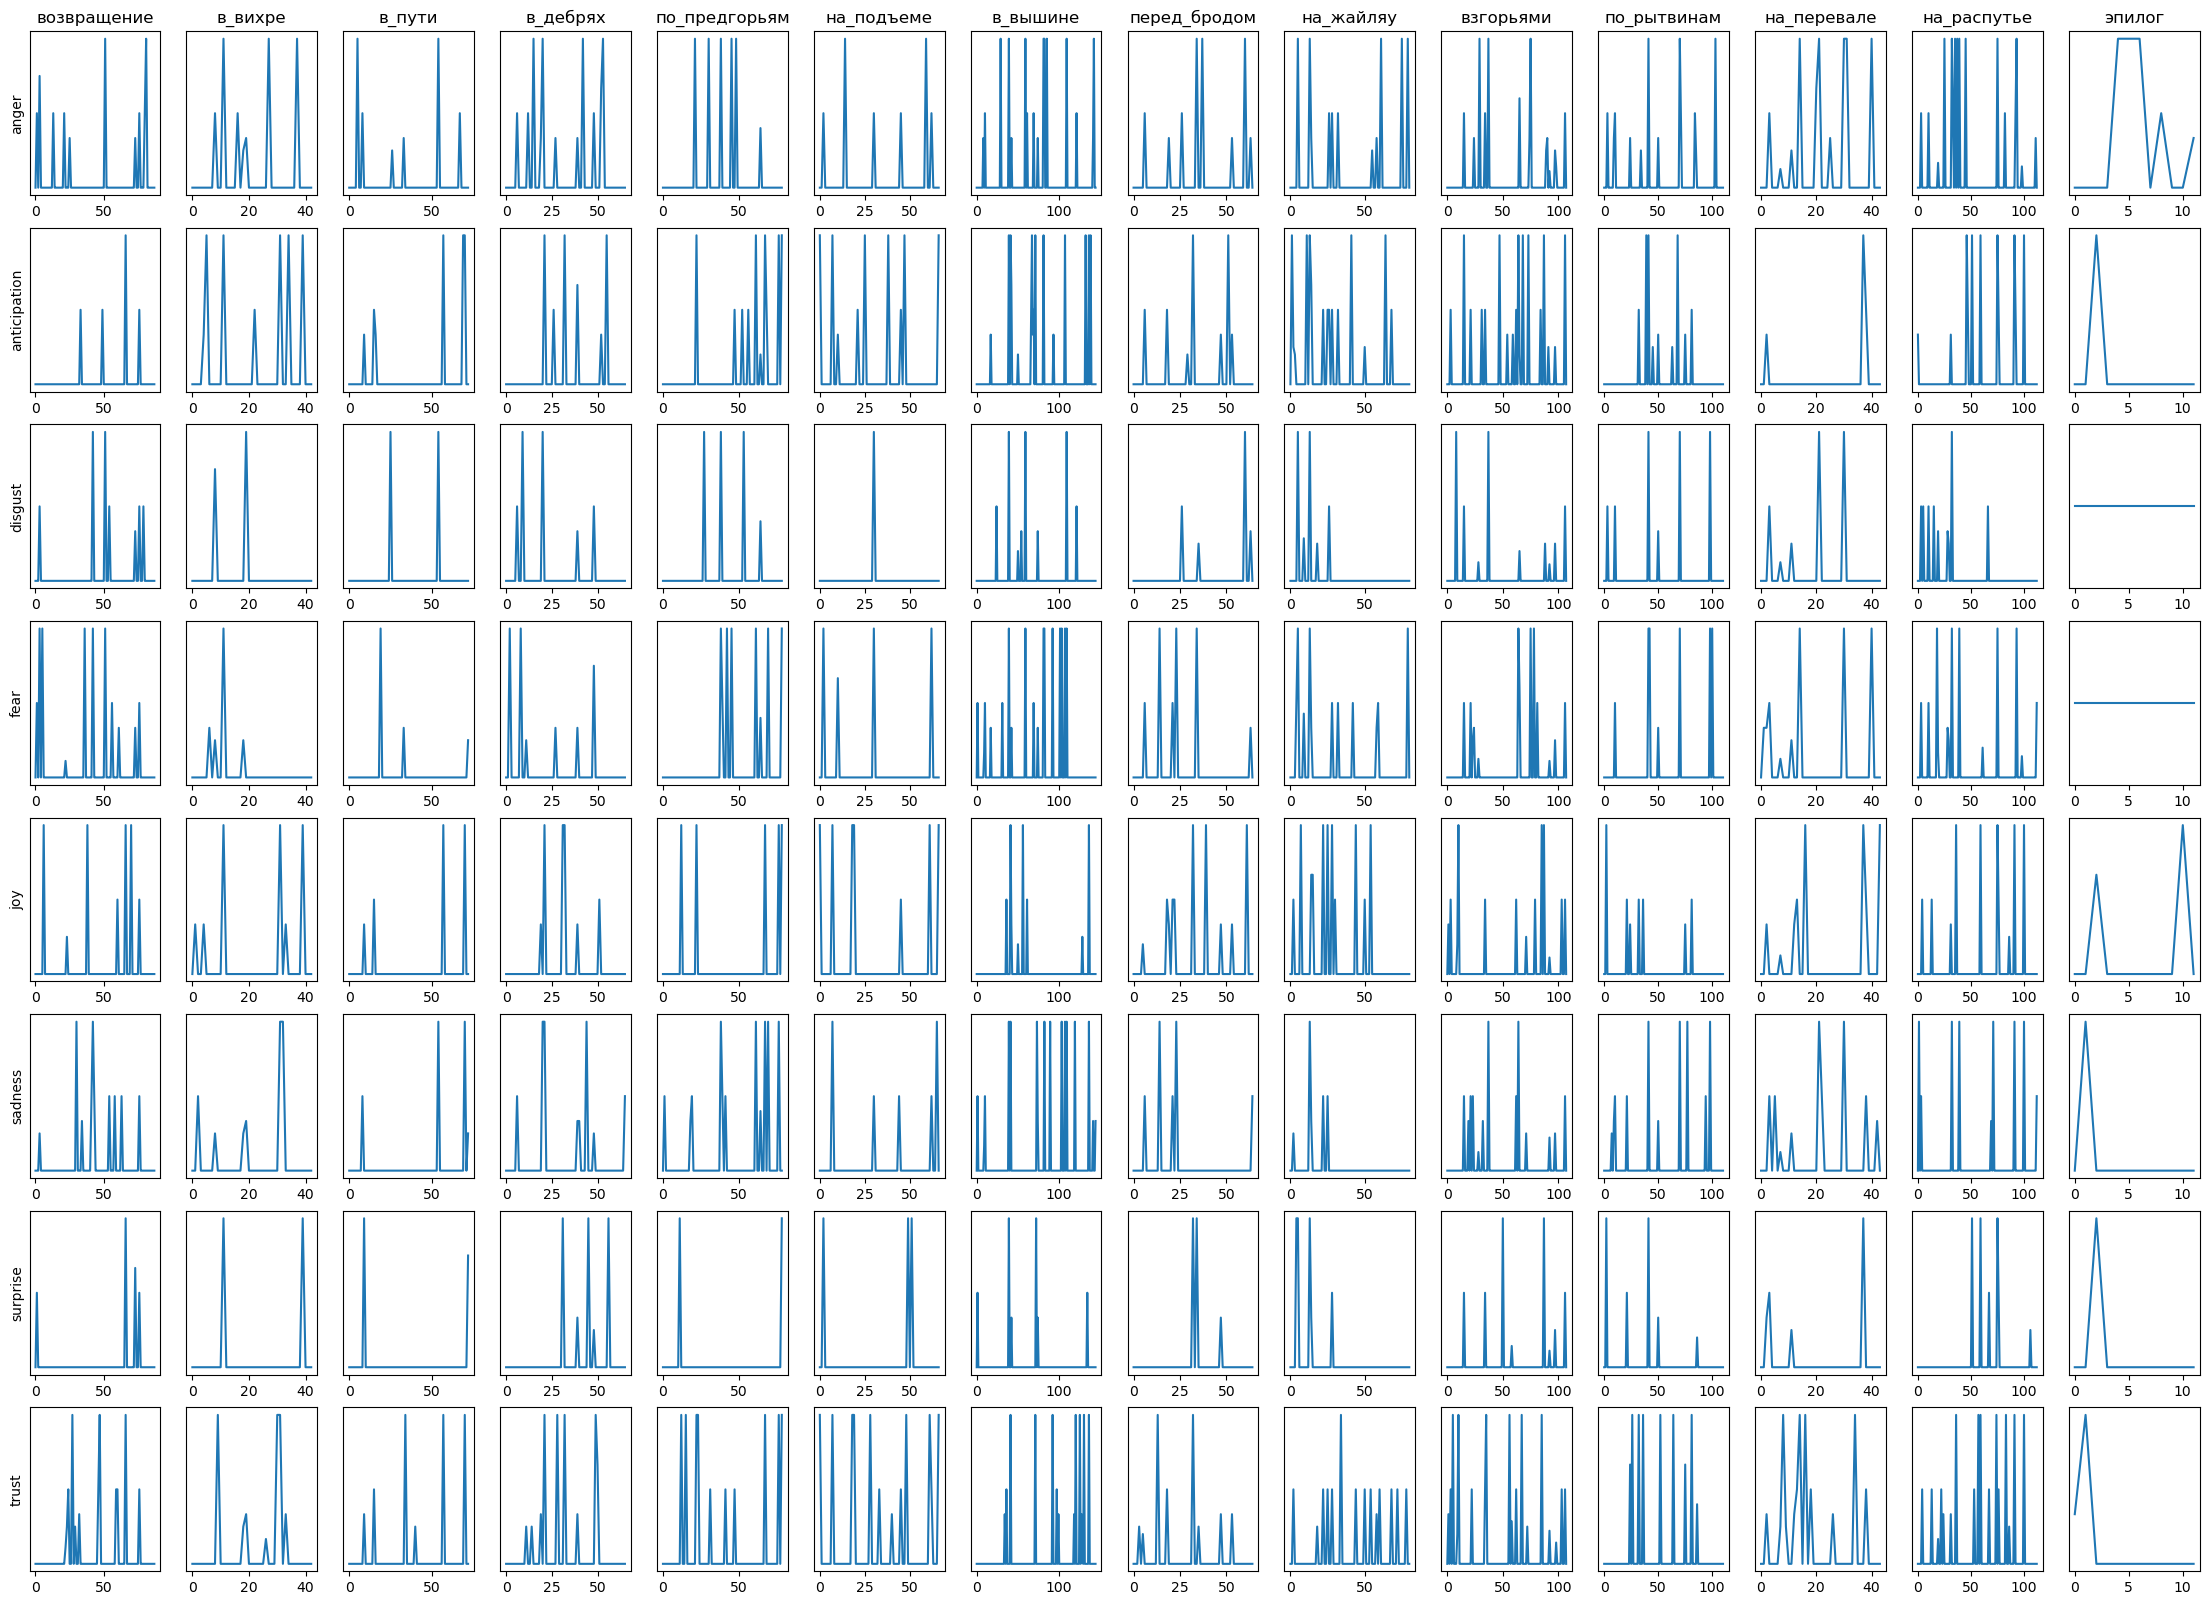

In [138]:
plot_emotions(ru_emotions, ru_part1_chapters, ru_part2_chapters, step=10)

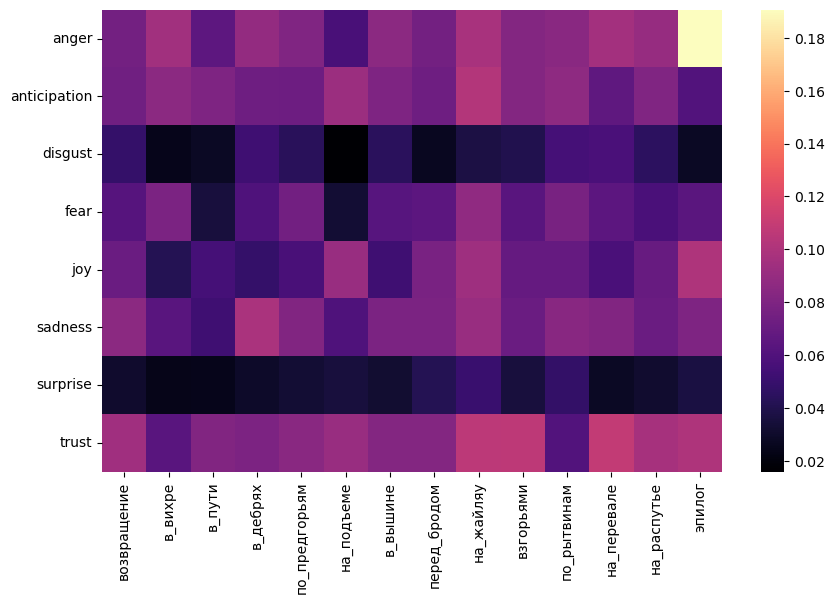

In [139]:
plot_emotion_heatmap(ru_emotion_mean, ru_part1_chapters, ru_part2_chapters)

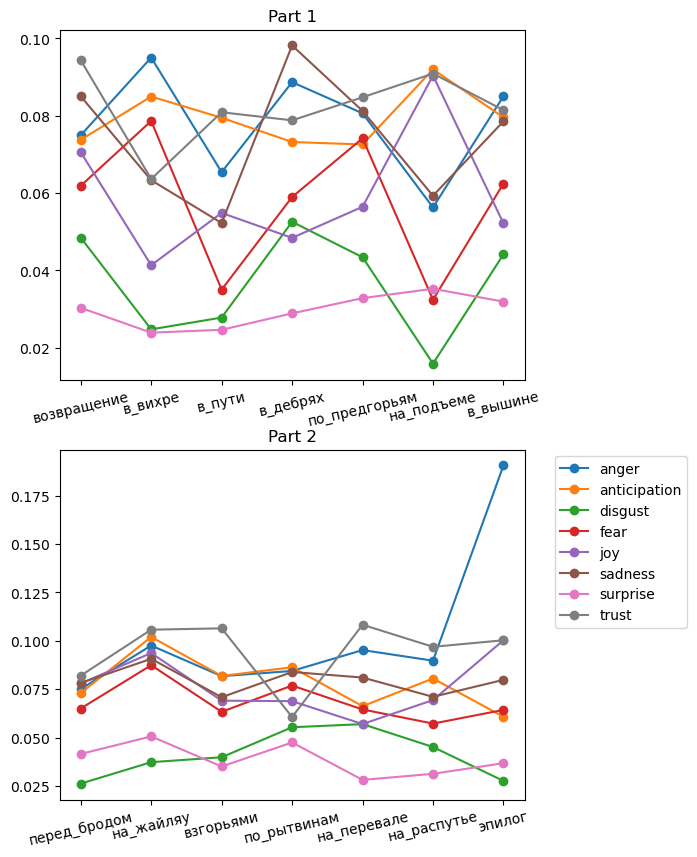

In [140]:
plot_emotions_mean(ru_emotion_mean)

## Sentiment Analysis Original Kazakh Version

In [141]:
kaz_emotions = {}

for part in parts:
    kaz_emotions[part] = {}
    book = books['kazakh']
    for chapter in book[part]:
        kaz_emotions[part][chapter] = []
        for sentence in book[part][chapter]:
            emotion = get_emotion(kaz_emotion_dict, sentence)
            if emotion:
                kaz_emotions[part][chapter].append(np.mean(emotion, axis=0))

In [142]:
kaz_emotion_mean = {}

for part in parts:
    kaz_emotion_mean[part] = {}
    for chapter in kaz_emotions[part].keys():
      kaz_emotion_mean[part][chapter] = np.mean(kaz_emotions[part][chapter], axis=0)

In [143]:
kaz_part1_chapters = [chapter for chapter in kaz_emotions['part1'].keys()]
kaz_part2_chapters = [chapter for chapter in kaz_emotions['part2'].keys()]

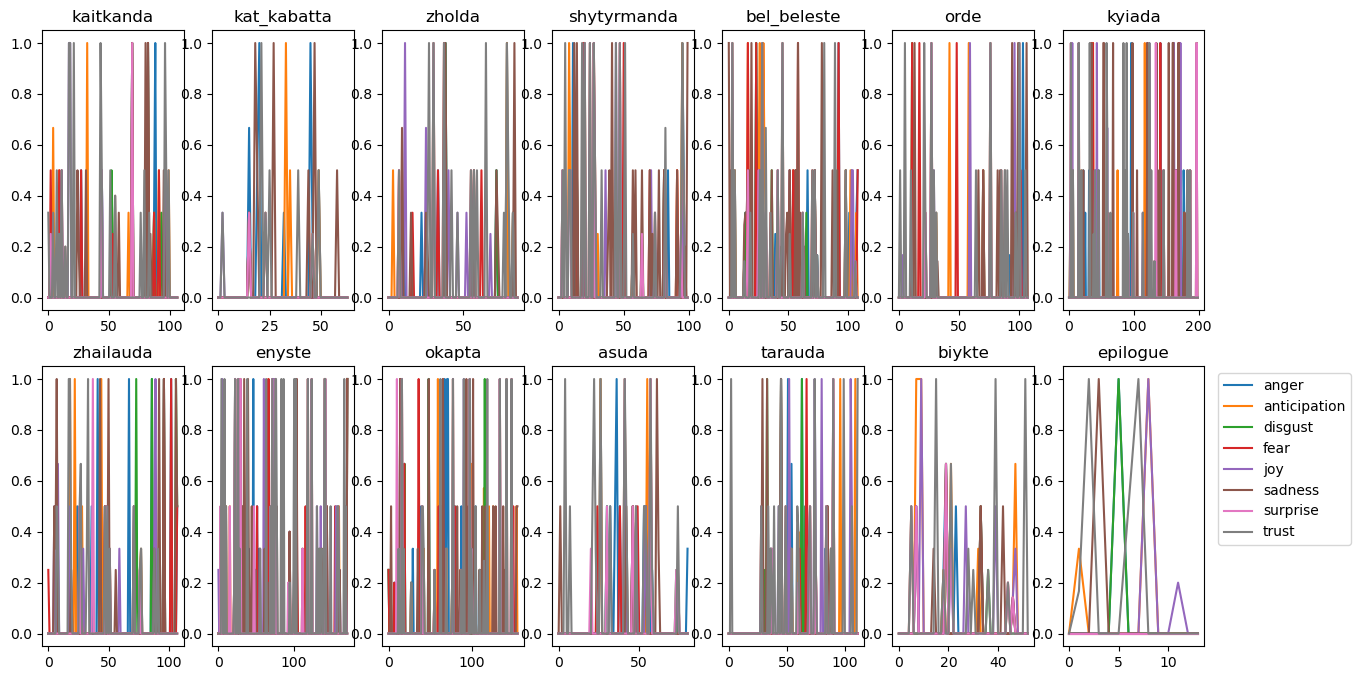

In [144]:
plot_emotions2(kaz_emotions, kaz_part1_chapters, kaz_part2_chapters, step=10)

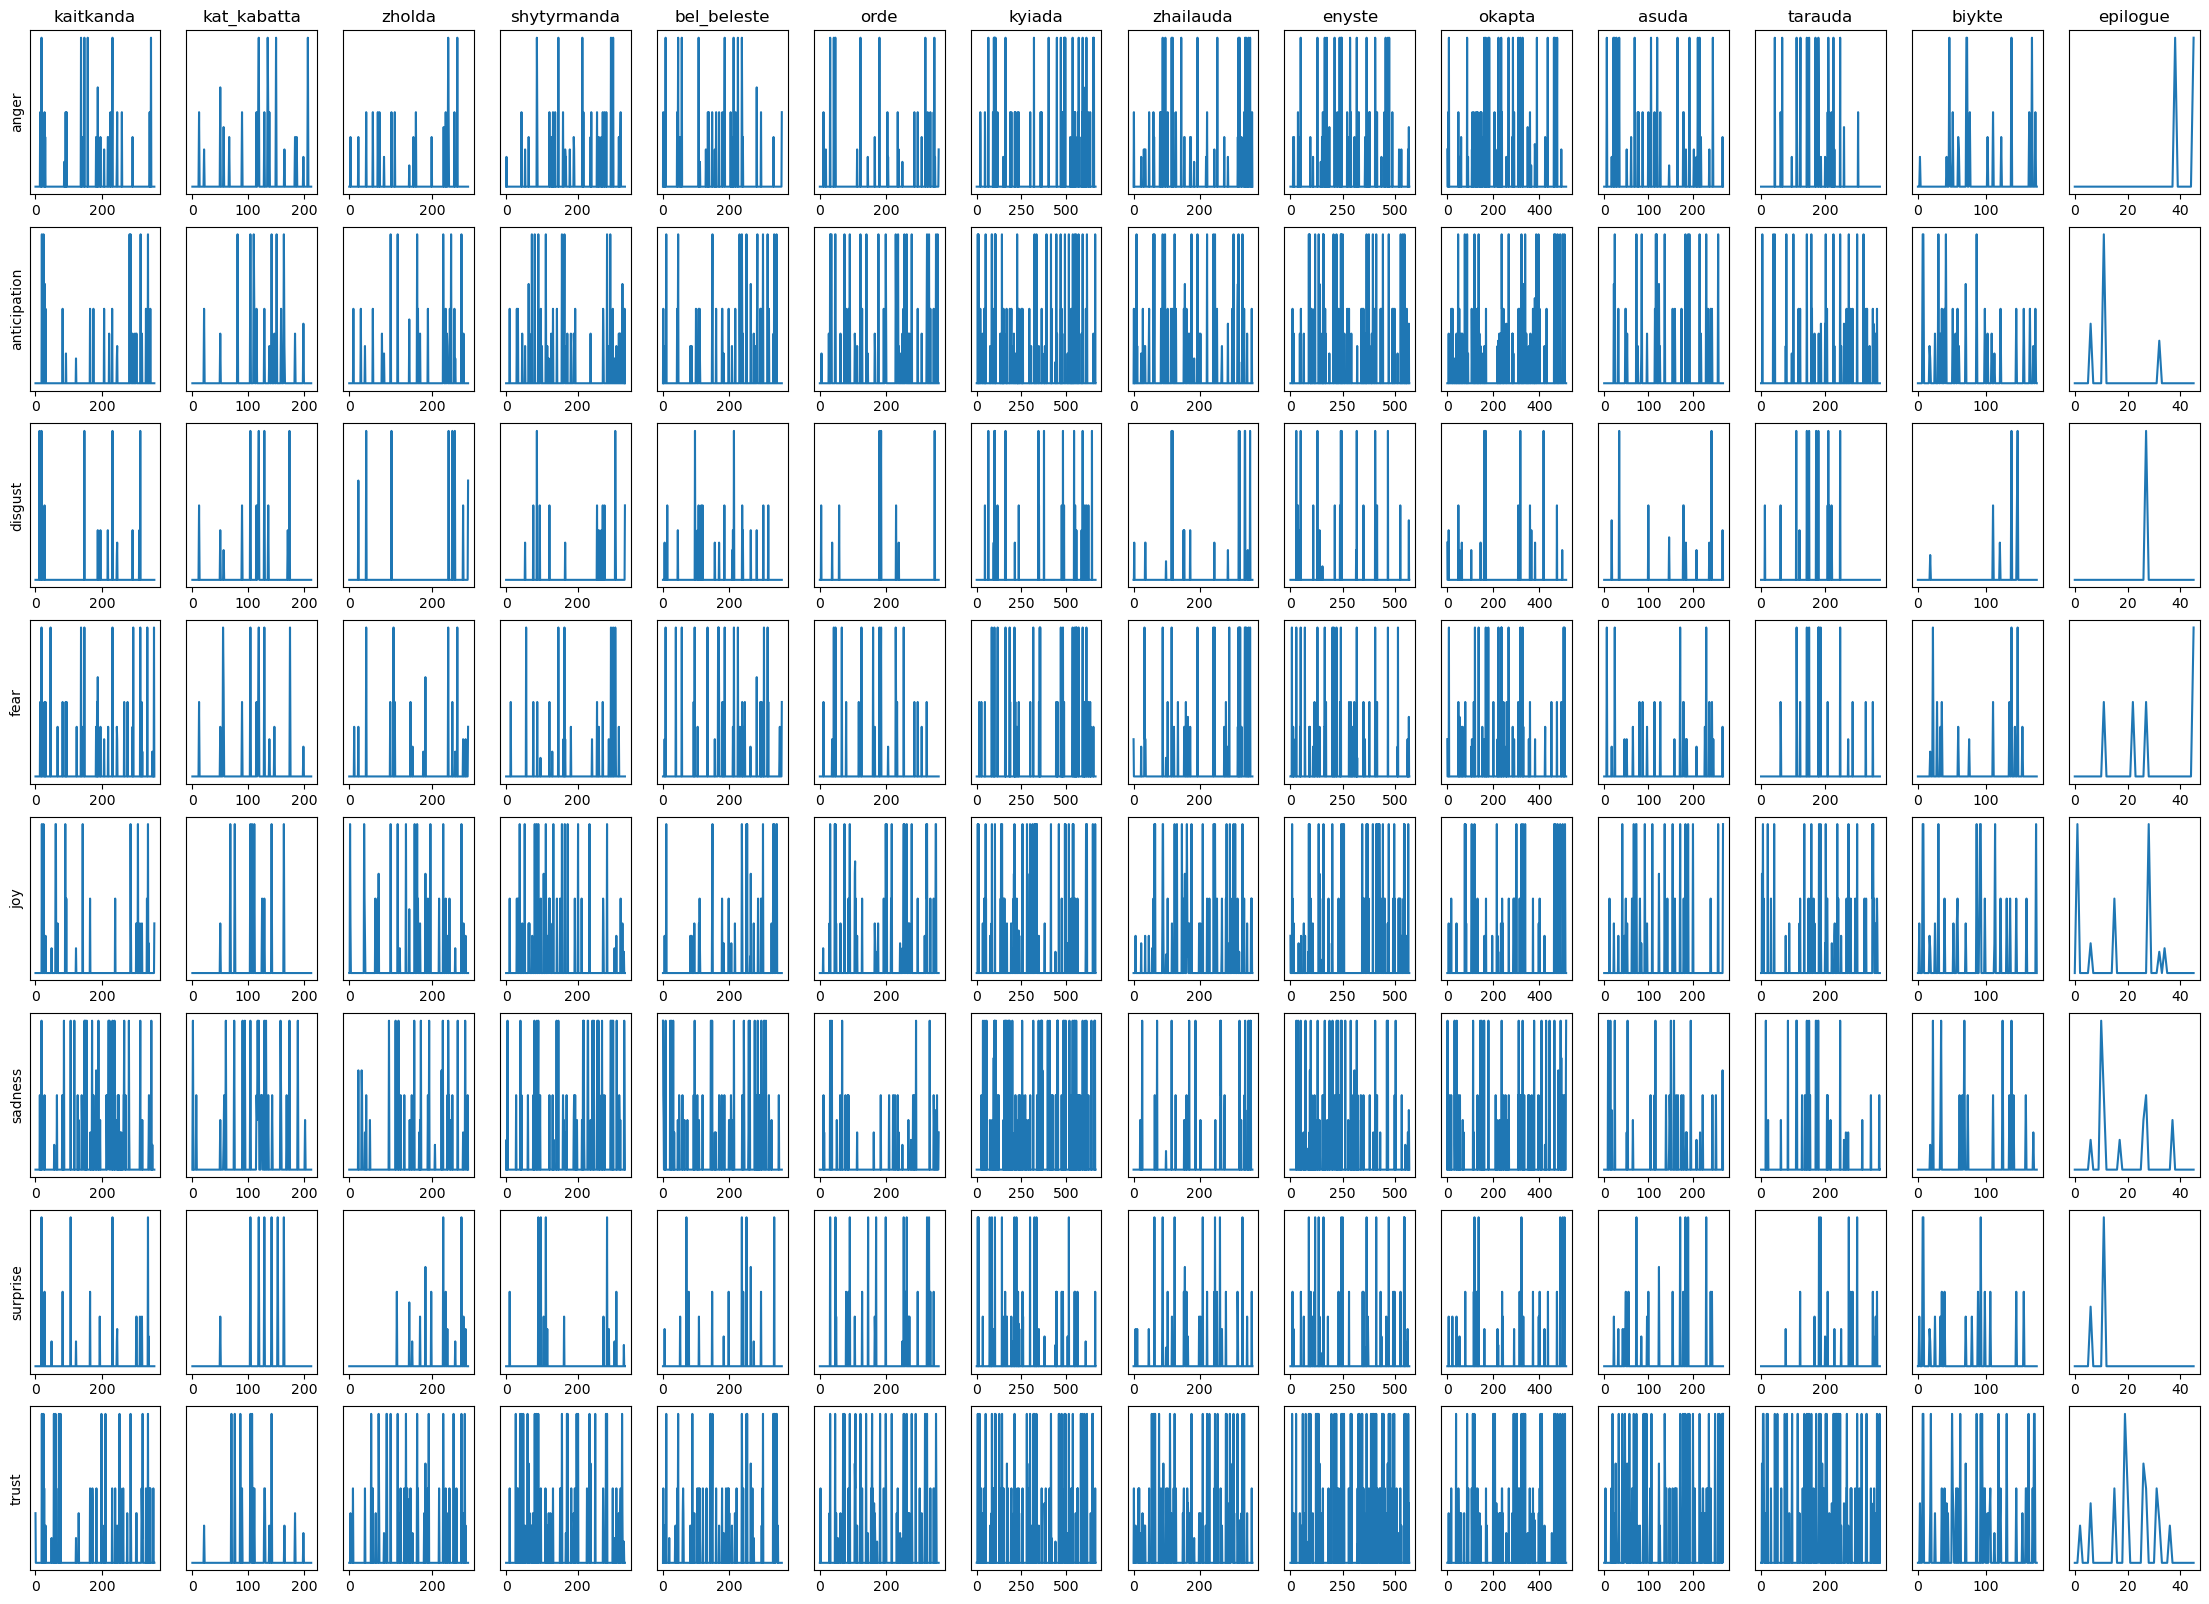

In [145]:
plot_emotions(kaz_emotions, kaz_part1_chapters, kaz_part2_chapters, step=3)

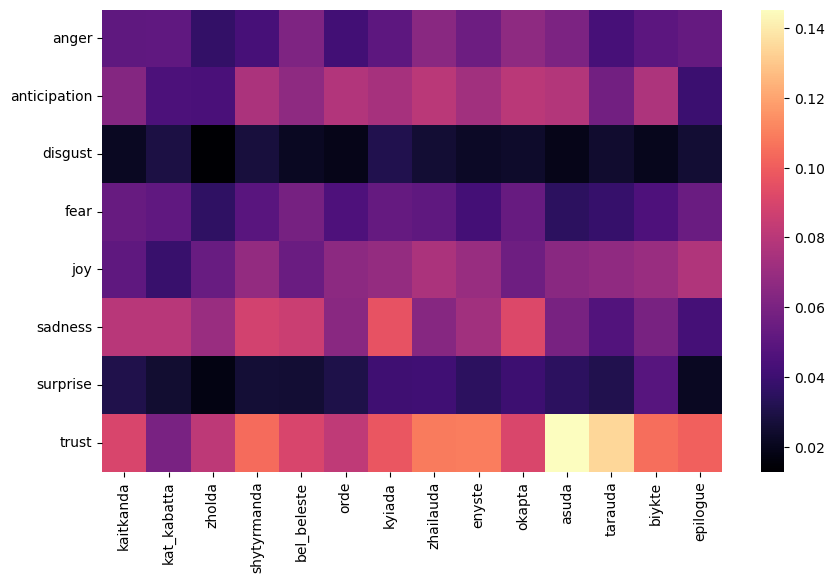

In [146]:
plot_emotion_heatmap(kaz_emotion_mean, kaz_part1_chapters, kaz_part2_chapters)

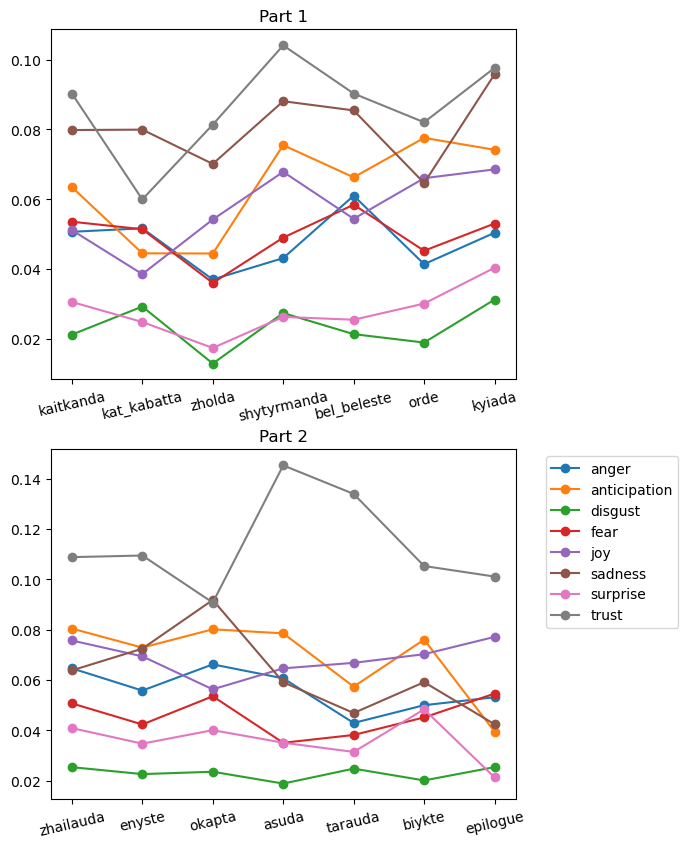

In [147]:
plot_emotions_mean(kaz_emotion_mean)

# Calculate distances

In [148]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, manhattan_distances

In [149]:
# en and ru
en_emotion_matrix = np.array([en_emotions_mean['part1'][chapter] for chapter in chapter1] + [en_emotions_mean['part2'][chapter] for chapter in chapter2])
ru_emotion_matrix = np.array([ru_emotion_mean['part1'][chapter] for chapter in ru_part1_chapters] + [ru_emotion_mean['part2'][chapter] for chapter in ru_part2_chapters])
kaz_emotion_matrix = np.array([kaz_emotion_mean['part1'][chapter] for chapter in kaz_part1_chapters] + [kaz_emotion_mean['part2'][chapter] for chapter in kaz_part2_chapters])

In [164]:
en_emotion_matrix

array([[0.10186454, 0.0934358 , 0.0648928 , 0.1178589 , 0.07633199,
        0.11985977, 0.04255737, 0.15458092],
       [0.10005802, 0.08665085, 0.03859809, 0.09814749, 0.04472737,
        0.07362439, 0.04409696, 0.110041  ],
       [0.08226107, 0.11223395, 0.04495429, 0.07219941, 0.09154382,
        0.07501496, 0.02868507, 0.13943572],
       [0.10130924, 0.12211631, 0.05626421, 0.09886647, 0.08763444,
        0.12132868, 0.04834095, 0.14077769],
       [0.08105677, 0.10909547, 0.04763538, 0.09044751, 0.07873524,
        0.10716955, 0.0578848 , 0.13214094],
       [0.05506691, 0.14036783, 0.03107514, 0.05957168, 0.11674185,
        0.07213019, 0.0474914 , 0.14204764],
       [0.09296566, 0.11940041, 0.05139596, 0.09092644, 0.09486037,
        0.09164619, 0.05026236, 0.14485135],
       [0.06507797, 0.12777106, 0.04250382, 0.07521013, 0.12183663,
        0.0776355 , 0.04613291, 0.13840982],
       [0.08654499, 0.08911356, 0.04819468, 0.0998346 , 0.08267954,
        0.09931567, 0.045437

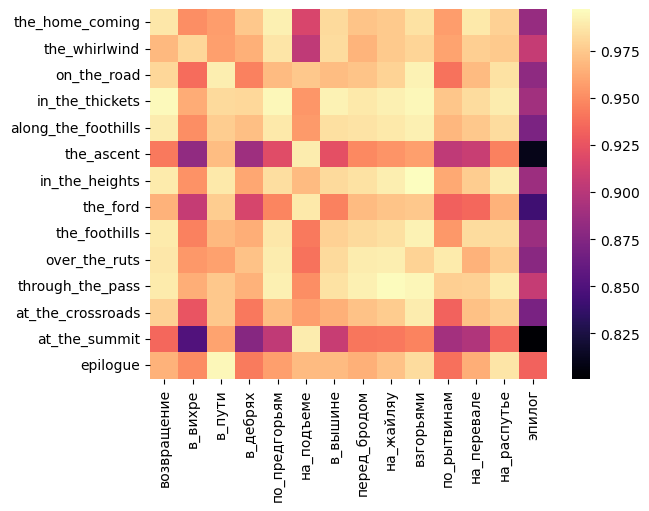

In [161]:
sns.heatmap(cosine_similarity(en_emotion_matrix, ru_emotion_matrix), cmap='magma')
plt.yticks(ticks=np.arange(0.5, 14.5, 1), labels=chapter1 + chapter2, rotation=0)
plt.xticks(ticks=np.arange(0.5, 14.5, 1), labels=ru_part1_chapters + ru_part2_chapters, rotation=90)
plt.show()

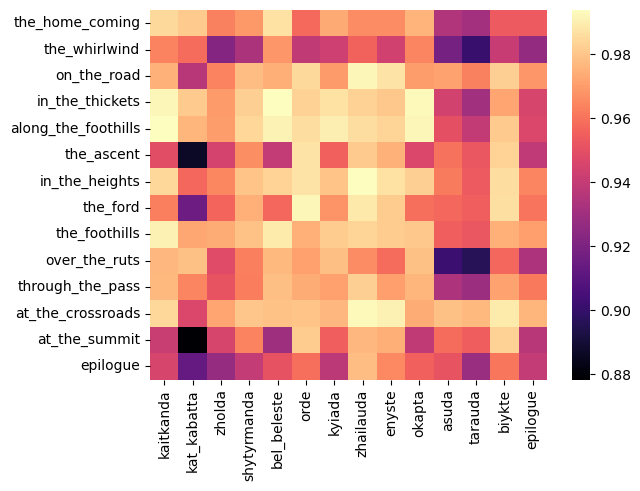

In [162]:
# en and kaz
sns.heatmap(cosine_similarity(en_emotion_matrix, kaz_emotion_matrix), cmap='magma')
plt.yticks(ticks=np.arange(0.5, 14.5, 1), labels=chapter1 + chapter2, rotation=0)
plt.xticks(ticks=np.arange(0.5, 14.5, 1), labels=kaz_part1_chapters + kaz_part2_chapters, rotation=90)
plt.show()

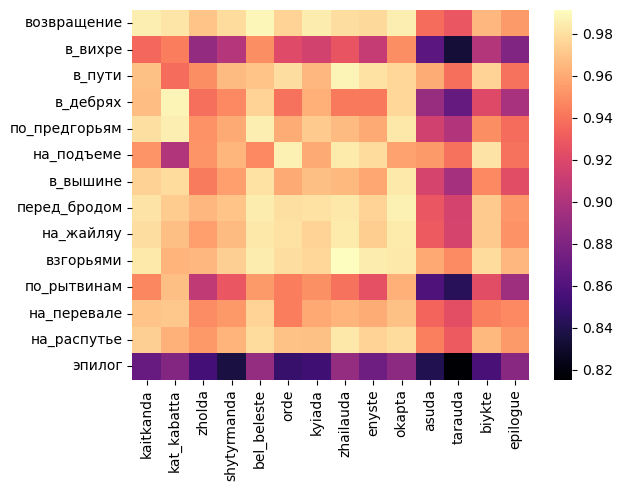

In [163]:
# ru and kaz
sns.heatmap(cosine_similarity(ru_emotion_matrix, kaz_emotion_matrix), cmap='magma')
plt.yticks(ticks=np.arange(0.5, 14.5, 1), labels=ru_part1_chapters + ru_part2_chapters, rotation=0)
plt.xticks(ticks=np.arange(0.5, 14.5, 1), labels=kaz_part1_chapters + kaz_part2_chapters, rotation=90)
plt.show()